# Self Driving Car Engineer Nanodegree

## Project 2 : Advanced Lane Finding 

---

### The main aim of this project is to implement the following steps:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import all the required functions

In [322]:
import pickle
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
__DEBUG__ = True

## Camera Calibration
#### The calibration of camera can be done using the chess board images provided in camera_cal folder

17  images were eligible for calibration


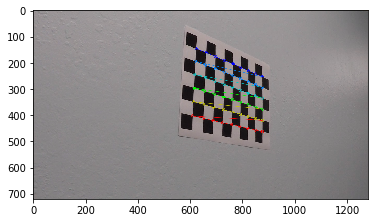

In [35]:
def camera_calibrate(images_list, nx_columns, ny_rows, root_folder = ""):
    object_points_superset = []
    image_points_superset = []
    eligible_images = 0
    for i in range(len(images_list)):
        img = cv2.imread(root_folder+images_list[i])
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        gray_chess_board = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_chess_board, (nx, ny), None)
        if ret == True:
            if __DEBUG__:
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
            eligible_images = eligible_images + 1
            object_points_superset.append(objp)
            image_points_superset.append(corners)
            
    print(eligible_images, " images were eligible for calibration")
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points_superset, image_points_superset, 
                                                       gray_chess_board.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs
        

        
ret, mtx, dist, rvecs, tvecs = camera_calibrate(os.listdir("camera_cal"), 9, 6, "camera_cal//")

# Undistortion

#### Here, the image is undistorted using the mtx and dist parameters, that we got as output from the calibration of camera

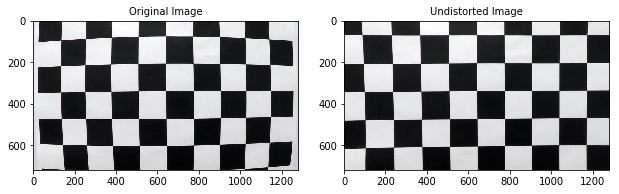

In [97]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

if __DEBUG__:
    #ret, mtx, dist, rvecs, tvecs = camera_calibrate(os.listdir("camera_cal"), 9, 6, "camera_cal//")
    test_image = cv2.imread("camera_cal//calibration1.jpg")
    undistorted_image = (undistort(test_image))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(undistorted_image)
    ax2.set_title('Undistorted Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Sobel gradient masking and HLS masking

In [231]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, sobel_thresh=(0,255)):
    temp_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobely**2 + sobelx**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(gradmag)
    binary_output[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grad_direction)
    binary_output[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    return binary_output

def combined_threshold(image, sobel_kernel=15, threshold_array={'x':(20,100), 'y':(20,100), 'mag':(30,100), 'dir':(0.7, 1.3)}):
    gradx = abs_sobel_thresh(image, 'x', sobel_kernel, sobel_thresh=threshold_array['x'])
    grady = abs_sobel_thresh(image, 'y', sobel_kernel, sobel_thresh=threshold_array['y'])
    mag_binary = mag_thresh(image, sobel_kernel, mag_thresh=threshold_array['mag'])
    dir_binary = dir_threshold(image, sobel_kernel, thresh=threshold_array['dir'])

    combined_binary_image = np.zeros_like(dir_binary)
    combined_binary_image[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_binary_image

def s_channel_threshold(image, s_thresh=(0,255)):
    hls_image = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    s_channel = hls_image[:,:,2]
    s_binary_image = np.zeros_like(s_channel)
    s_binary_image[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary_image

def l_channel_threshold(image, l_thresh=(0,255)):
    hls_image = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    l_channel = hls_image[:,:,1]
    l_binary_image = np.zeros_like(l_channel)
    l_binary_image[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return l_binary_image

def h_channel_threshold(image, h_thresh=(0,255)):
    hls_image = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    h_channel = hls_image[:,:,0]
    h_binary_image = np.zeros_like(h_channel)
    h_binary_image[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary_image

def bitwise_and_binary_images(binary_image1, binary_image2):
    result_binary_image = np.zeros_like(binary_image1)
    result_binary_image[(binary_image1 == 1) & (binary_image2 == 1)] = 1
    return result_binary_image

def bitwise_or_binary_images(binary_image1, binary_image2):
    result_binary_image = np.zeros_like(binary_image1)
    result_binary_image[(binary_image1 == 1) | (binary_image2 == 1)] = 1
    return result_binary_image

def test_images(image_path):
    display_images = []
    testing_image = cv2.imread(image_path)
    testing_image = undistort(testing_image)
    #masked_image = combined_threshold(testing_image)
    threshold_array={'x':(50,180), 'y':(50,180), 'mag':(50,180), 'dir':(0.8, 1)}
    x_sobel = abs_sobel_thresh(testing_image, 'x',sobel_kernel=3, sobel_thresh=threshold_array['x'])
    y_soble = abs_sobel_thresh(testing_image, 'y', sobel_kernel=3, sobel_thresh=threshold_array['y'])
    mag_binary = mag_thresh(testing_image, sobel_kernel=3, mag_thresh=threshold_array['mag'])
    dir_binary = dir_threshold(testing_image, sobel_kernel=15, thresh=threshold_array['dir'])
    s_channel_image = s_channel_threshold(testing_image, (170,255))
    h_channel_image = h_channel_threshold(testing_image, (40,100))
    l_channel_image = l_channel_threshold(testing_image, (100,250))
    s_or_mag_image = bitwise_or_binary_images(s_channel_image, mag_binary)
    mag_and_dir_image = bitwise_and_binary_images(mag_binary, dir_binary)
    mag_or_dir_s_image = bitwise_or_binary_images(s_or_mag_image, mag_and_dir_image)
    mag_dir_s_l_image = bitwise_and_binary_images(mag_or_dir_s_image, l_channel_image)
    
    display_images.append([cv2.cvtColor(testing_image, cv2.COLOR_BGR2RGB), "Undistorted "+image_path.split("//")[1]])
    display_images.append([x_sobel, 'x sobel'])
    display_images.append([y_soble, 'y sobel'])
    display_images.append([mag_binary, 'mag_binary'])
    display_images.append([dir_binary, 'dir_binary'])
    display_images.append([s_channel_image, 's-channel'])
    display_images.append([l_channel_image, 'l-channel'])
    display_images.append([h_channel_image, 'h-channel'])
    display_images.append([s_or_mag_image, 's_or_mag_image'])
    display_images.append([mag_and_dir_image, 'mag_and_dir_image'])
    display_images.append([mag_or_dir_s_image, 'mag_or_dir_s_image'])
    display_images.append([mag_dir_s_l_image, 'mag_dir_s_l_image'])
    
    
    f, axes = plt.subplots(3, 4, figsize=(16, 9))
    axes = axes.flatten()
    f.tight_layout()
    #print (axes[0])
    #axes[0].imshow(cv2.cvtColor(testing_image, cv2.COLOR_BGR2RGB))
    for i in range(len(axes)):
        axes[i].imshow(display_images[i][0])
        axes[i].set_title(display_images[i][1], fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


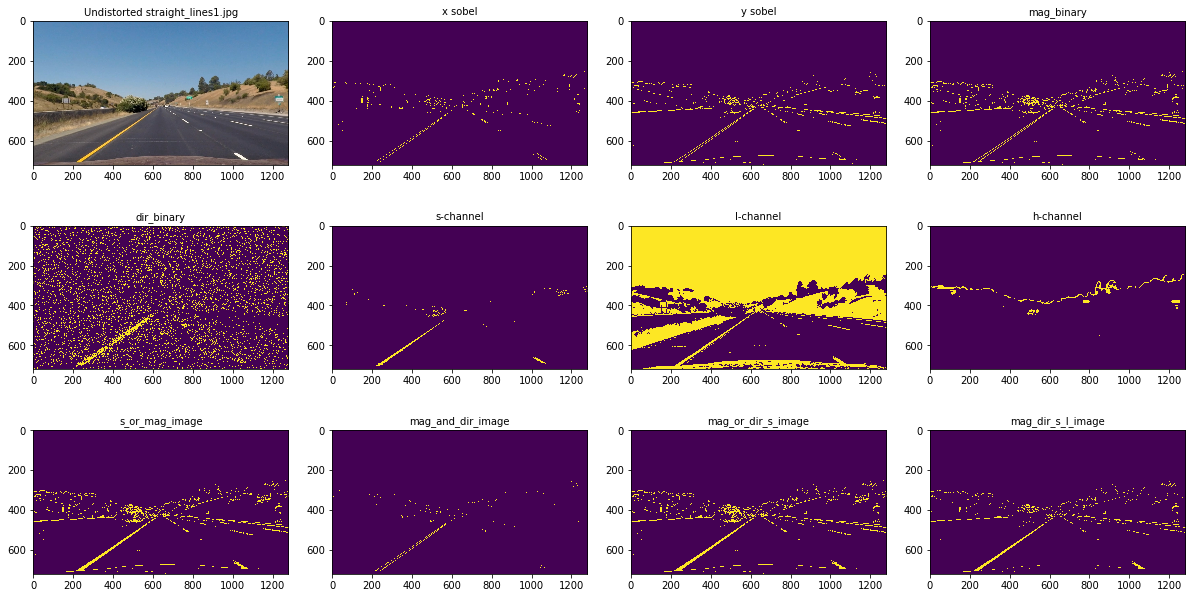

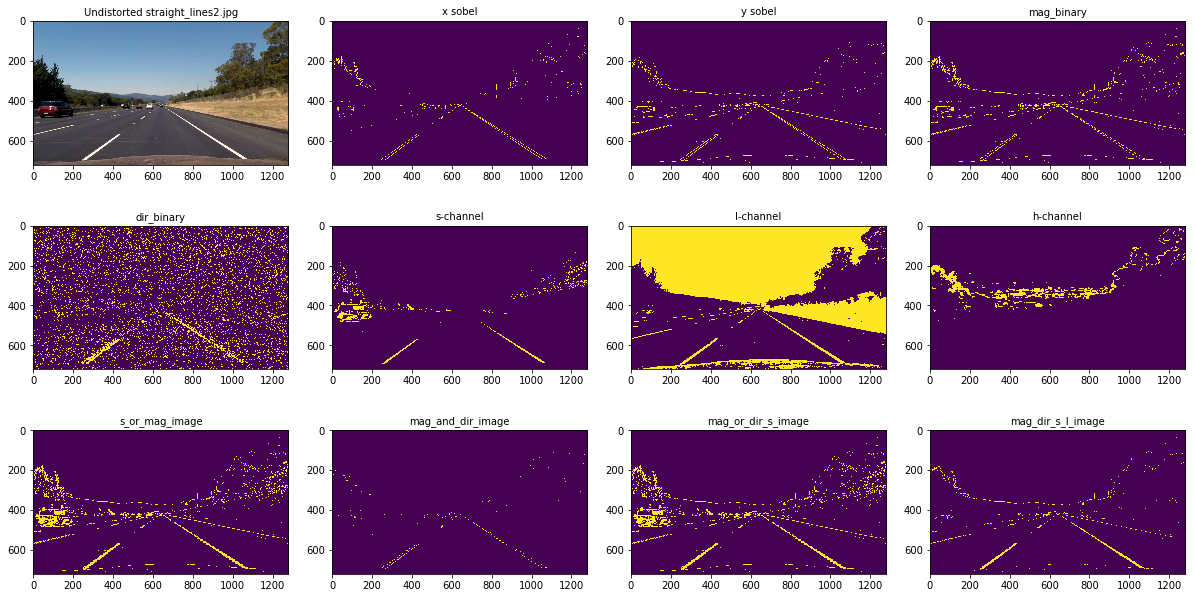

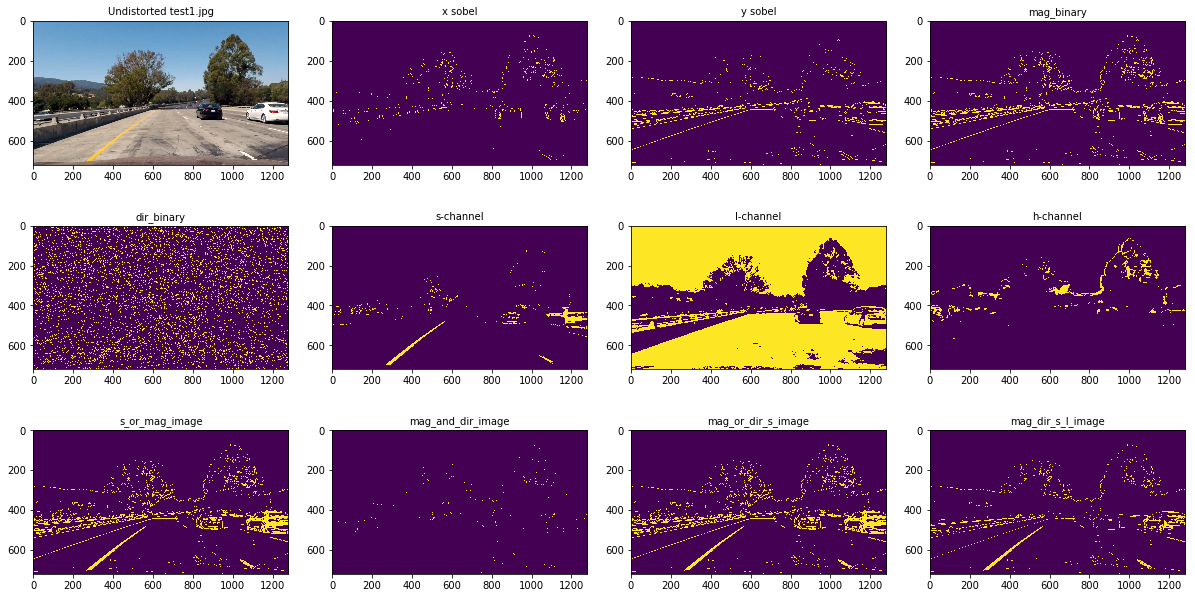

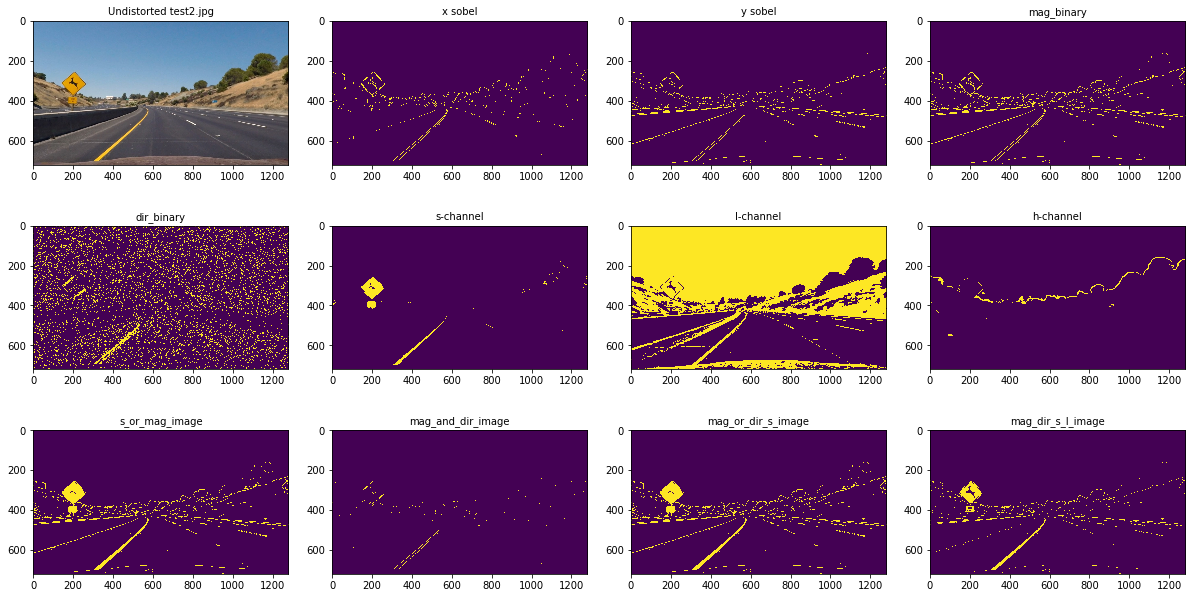

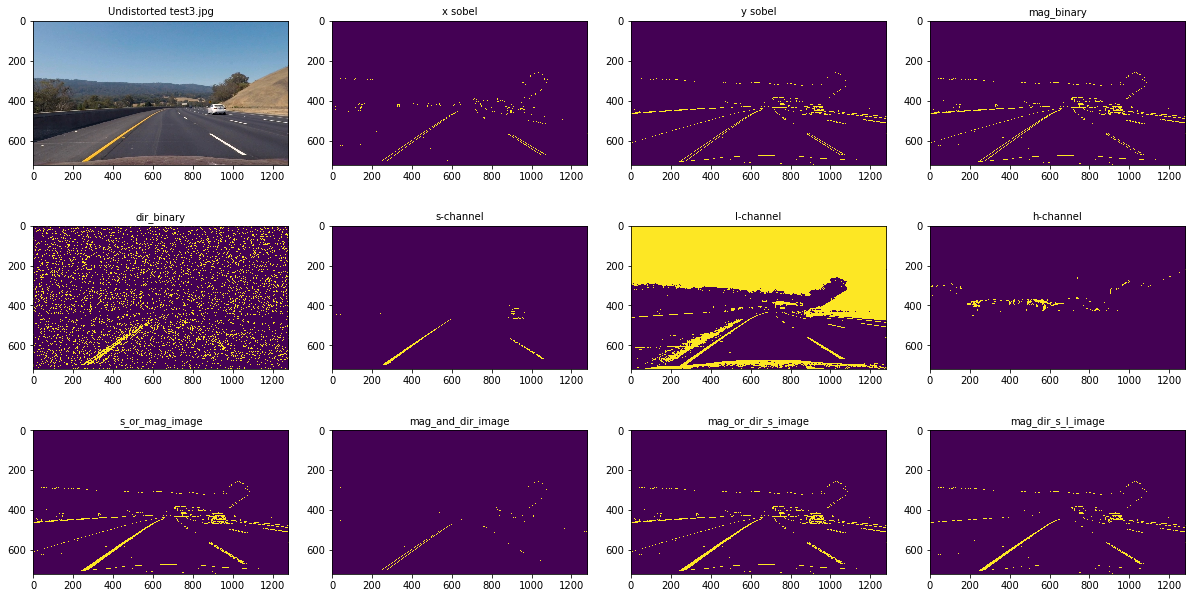

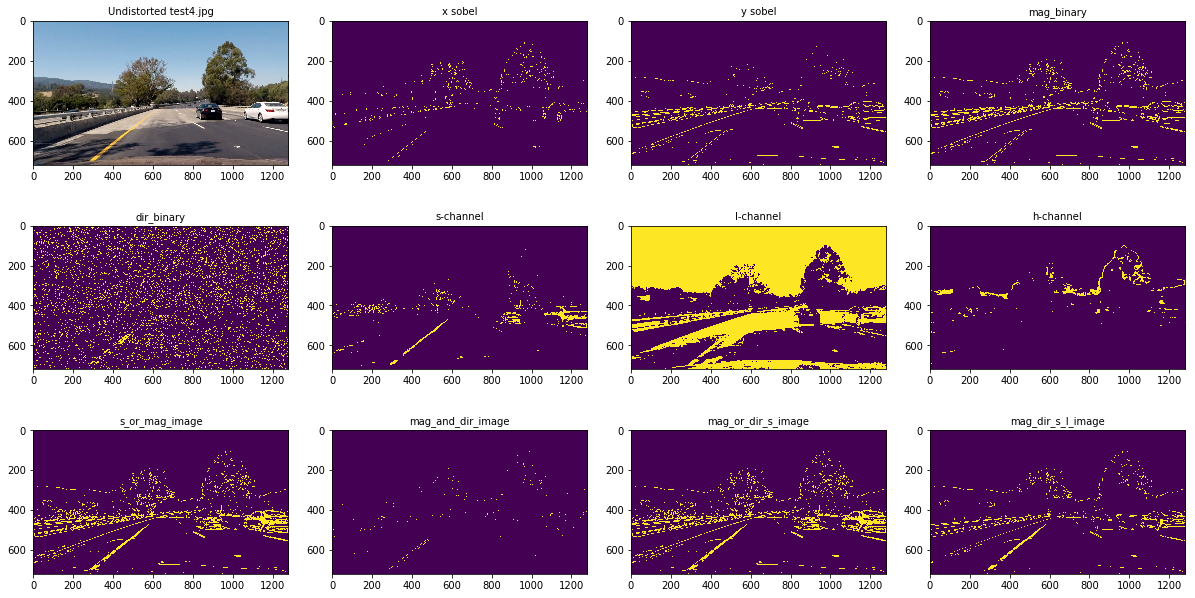

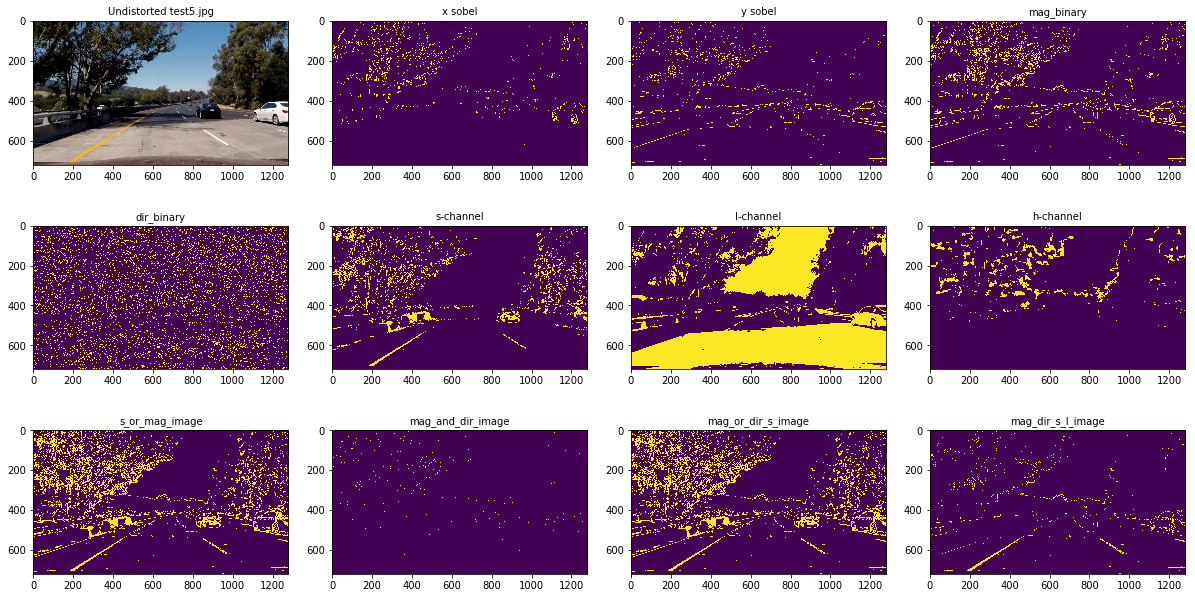

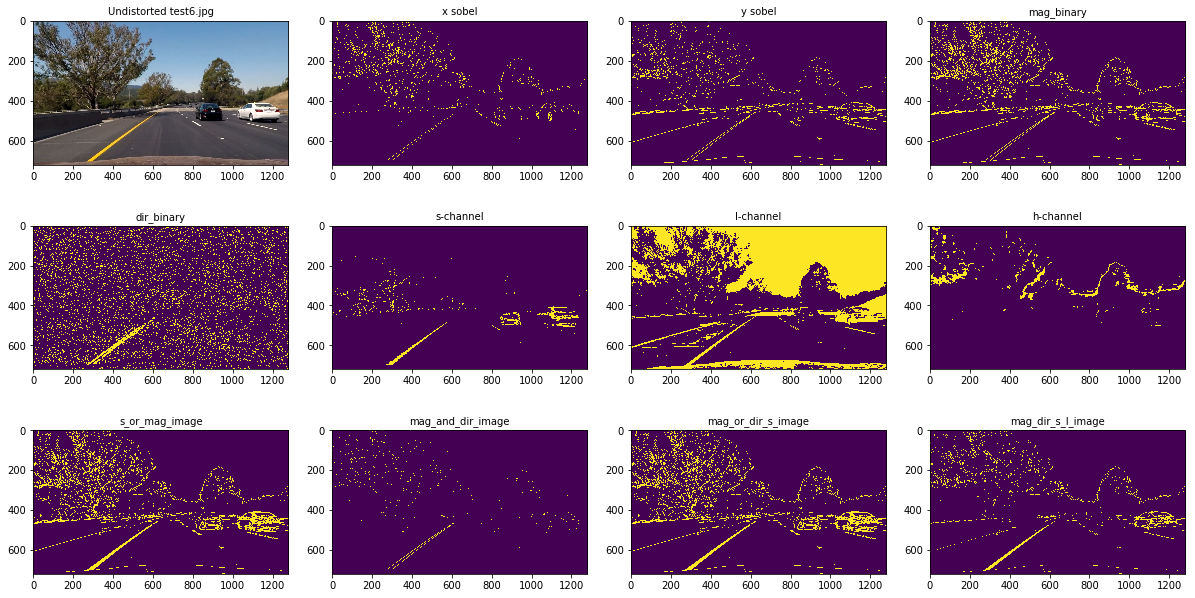

In [232]:
test_images("test_images//straight_lines1.jpg")
test_images("test_images//straight_lines2.jpg")
test_images("test_images//test1.jpg")
test_images("test_images//test2.jpg")
test_images("test_images//test3.jpg")
test_images("test_images//test4.jpg")
test_images("test_images//test5.jpg")
test_images("test_images//test6.jpg")

## Conclusion of above observation:
* The h-channel is of no use in finding the lane
* The s-channel works really good in identifying the lane lines
* The angular (a.k.a direction) binary finds the lane in road with darker shade, but also have too much noise
    - Hence, this can be combined with magnitude binary (using bitwise-and)
* The x and y sobel works good with road with darker shade and finding white lanes, so do the magnitude binary
    * Hence, the magnitude binary can be used alongside s-channel (bitwise-or) 
* The l-channel works good in road with darker shade, but when the road shade changes, no lanes are detected (pixels of enitre road is activated)
    * Hence, this can be used as a final filter, after the magnitude, direction and s-channel filtering

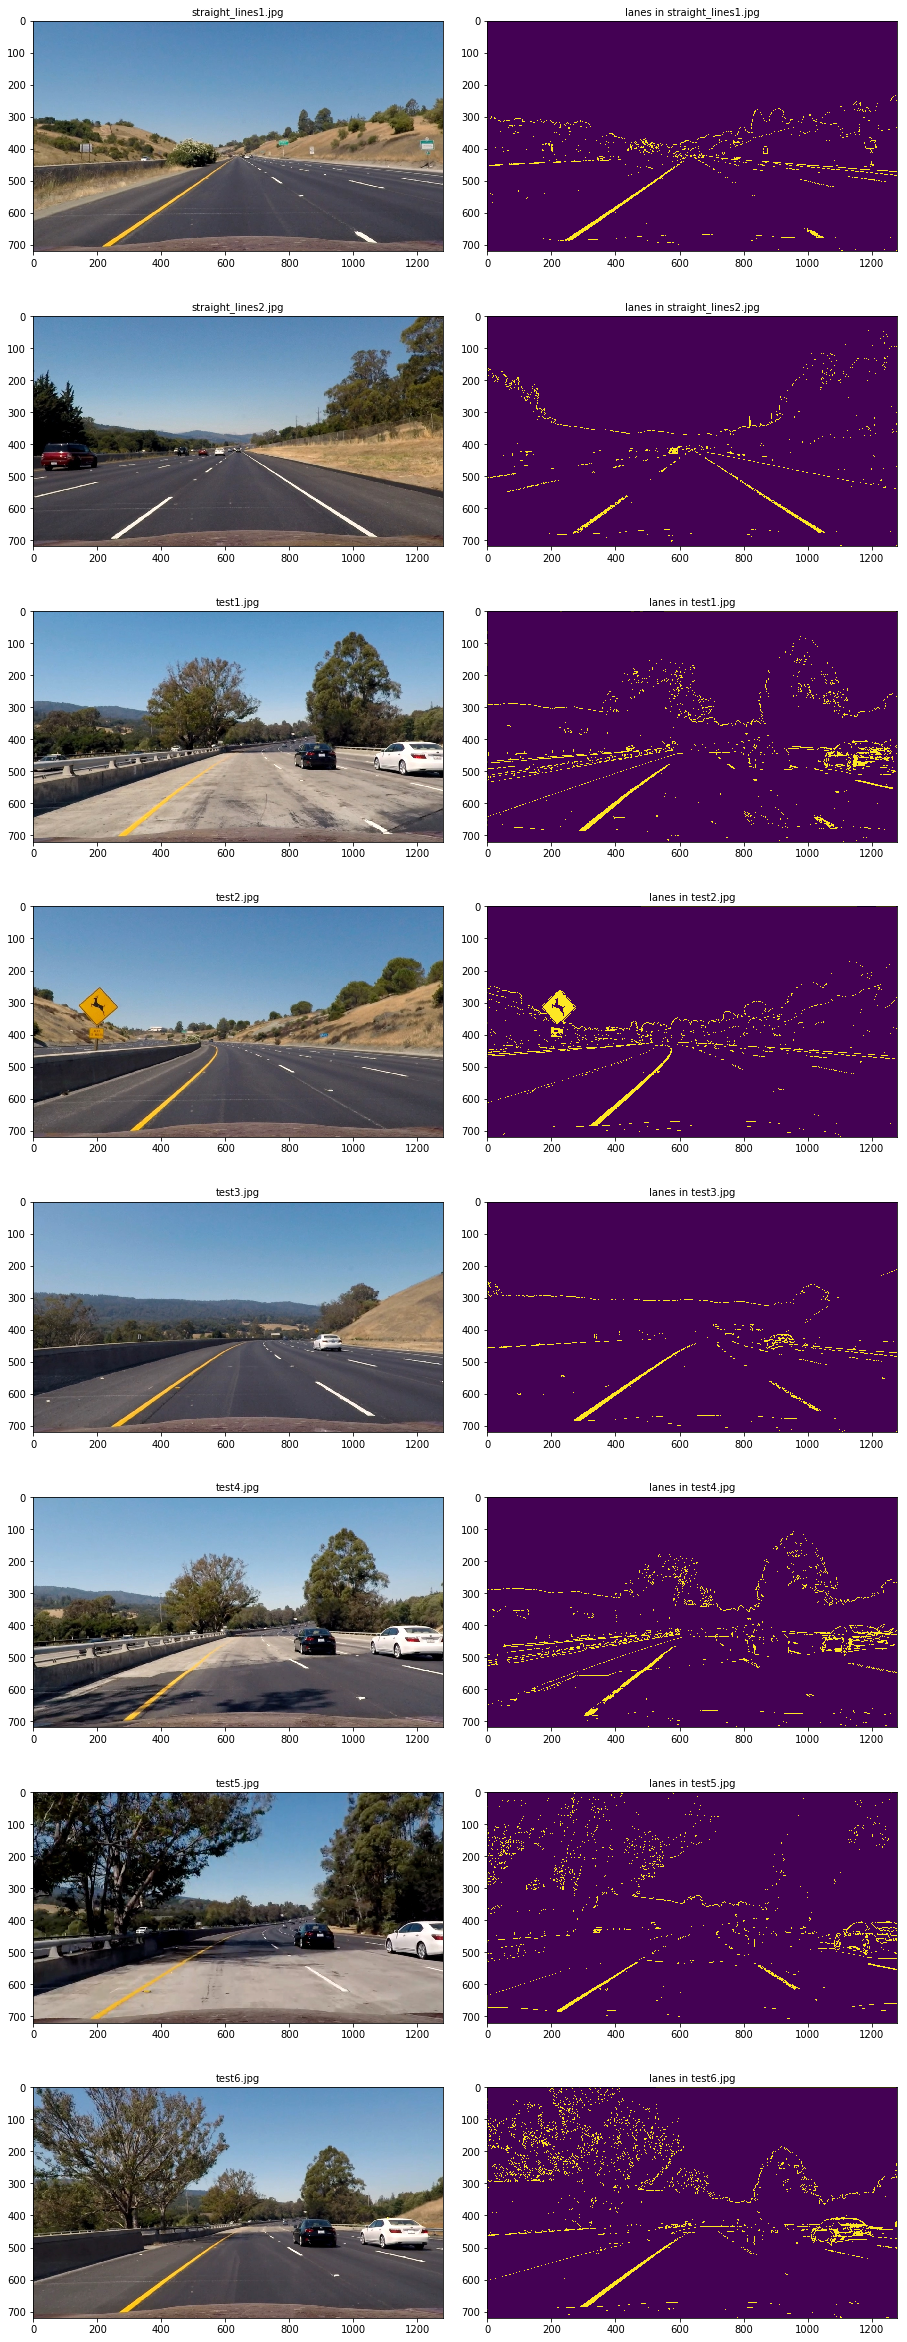

In [190]:
def lane_filter(image):
    threshold_array={'mag':(50,180), 'dir':(0.8, 1), 's':(170,255), 'l':(100,250)}
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=threshold_array['mag'])
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=threshold_array['dir'])
    s_channel_image = s_channel_threshold(image, threshold_array['s'])
    l_channel_image = l_channel_threshold(image, threshold_array['l'])
    s_or_mag_image = bitwise_or_binary_images(s_channel_image, mag_binary)
    mag_and_dir_image = bitwise_and_binary_images(mag_binary, dir_binary)
    mag_or_dir_s_image = bitwise_or_binary_images(s_or_mag_image, mag_and_dir_image)
    mag_dir_s_l_image = bitwise_and_binary_images(mag_or_dir_s_image, l_channel_image)
    return mag_dir_s_l_image

if __DEBUG__:
    display_images=[]
    for image_name in os.listdir("test_images"):
        test_image = cv2.imread("test_images//"+image_name)
        display_images.append([undistort(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)),image_name])
        display_images.append([lane_filter(test_image),"lanes in "+image_name])
    f, axes = plt.subplots(8, 2, figsize=(12, 36))
    axes = axes.flatten()
    f.tight_layout()
    for i in range(len(axes)):
        axes[i].imshow(display_images[i][0])
        axes[i].set_title(display_images[i][1], fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective change:
#### The perspective change requires Perspective transform matrix M, and inverse perspective transform matrix Minv to change it back to original perspective.
* We shall have a singleton class here, that produces the 2 matrices, as this will stay the same for entire process
* We shall consider the test image straight_lines1.jpg for computing these matrices

In [226]:
class Singleton_Perspective_Transform:
    
    def __init__(self):
        _src_points = np.float32([(203,720),(1100,720),(700,460),(582,460)])  #arbitrary points, manually obtained from image
        _dst_points = np.float32([(203,720),(1100,720),(1100,0),(203,0)])
        self.M = cv2.getPerspectiveTransform(_src_points,_dst_points)
        self.Minv = cv2.getPerspectiveTransform(_dst_points,_src_points)
    
    def warp_image(self, image):
        return cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    def unwarp_image(self, image):
        return cv2.warpPerspective(image, self.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
perspective_transform = Singleton_Perspective_Transform()

def warp_image(image):
    return perspective_transform.warp_image(image)
def unwarp_image(image):
    return perspective_transform.unwarp_image(image)

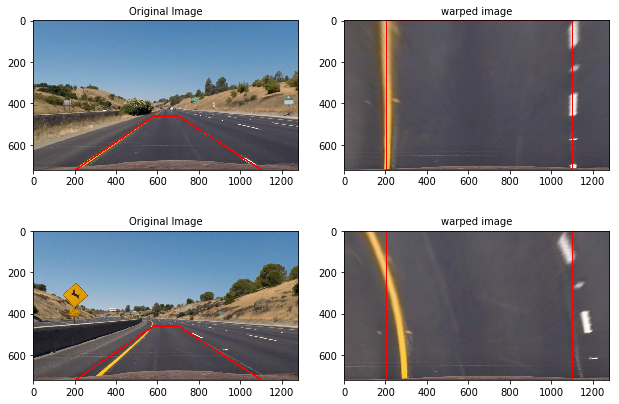

In [249]:
def test_warping():
    #original_image = mpimg.imread("test_images//straight_lines1.jpg")
    #cutved_image = mpimg.imread("test_images//test3.jpg")
    def draw_lines_on_original_image(img):
        cv2.line(img,(203,720),(1100,720),[255,0,0],thickness=5)
        cv2.line(img,(1100,720),(700,460),[255,0,0],thickness=5)
        cv2.line(img,(700,460),(582,460),[255,0,0],thickness=5)
        cv2.line(img,(582,460),(203,720),[255,0,0],thickness=5)
        return img
    
    def draw_lines_on_warped_image(img):
        cv2.line(img,(203,720),(1100,720),[255,0,0],thickness=5)
        cv2.line(img,(1100,720),(1100,0),[255,0,0],thickness=5)
        cv2.line(img,(203,720),(203,0),[255,0,0],thickness=5)
        cv2.line(img,(1100,0),(203,0),[255,0,0],thickness=5)        
        return img
        
    original_image = mpimg.imread("test_images//straight_lines1.jpg")
    undistoted_image = undistort(original_image)
    warped_image = warp_image(undistoted_image)
    undistoted_image = draw_lines_on_original_image(undistoted_image)
    warped_image = draw_lines_on_warped_image(warped_image)

    curved_image = mpimg.imread("test_images//test2.jpg")
    undistoted_curved_image = undistort(curved_image)
    warped_curved_image = warp_image(undistoted_curved_image)
    undistoted_curved_image = draw_lines_on_original_image(undistoted_curved_image)
    warped_curved_image = draw_lines_on_warped_image(warped_curved_image)
    
    
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(8, 6))
    f.tight_layout()
    ax1.imshow(undistoted_image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(warped_image)
    ax2.set_title('warped image', fontsize=10)
    ax3.imshow(undistoted_curved_image)
    ax3.set_title('Original Image', fontsize=10)
    ax4.imshow(warped_curved_image)
    ax4.set_title('warped image', fontsize=10)    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)       
        
if __DEBUG__:
    test_warping()

## Histogram and Sliding window search

#### To deduce the polynomial that fits the lane lines in the frames, we should first filter out the pixels that belong to lane lines. We shall use histogram and sliding window search for that, as shown below

In [307]:
def sliding_window_search(warped_binary_image):
    histogram = np.sum(warped_binary_image[warped_binary_image.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(warped_binary_image.shape[0]//nwindows)
    nonzero = warped_binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if __DEBUG__:
        out_img = np.dstack((warped_binary_image, warped_binary_image, warped_binary_image))
        
    # Stepping through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary_image.shape[0] - (window+1)*window_height
        win_y_high = warped_binary_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if __DEBUG__:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if __DEBUG__:
        return leftx, lefty, rightx, righty, out_img, histogram
    else:
        return leftx, lefty, rightx, righty

In [402]:
def fit_polynomial(warped_binary_image):
    if __DEBUG__:
        leftx, lefty, rightx, righty, out_img, histogram = sliding_window_search(warped_binary_image)
    else:
        leftx, lefty, rightx, righty = sliding_window_search(warped_binary_image)

    # second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print("Left Lane  :", left_fit[0],"y2 +  ",left_fit[1],"y +  ",left_fit[2] )
    print("Right Lane :", right_fit[0],"y2 +  ",right_fit[1],"y +  ",right_fit[2] )

    # x and y values for plotting
    ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    if __DEBUG__:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #temp_out_img = plt.plot(left_fitx, ploty, color='yellow')
        #temp_out_img = plt.plot(right_fitx, ploty, color='yellow')

        return histogram, out_img, left_fit, right_fit, left_fitx, right_fitx, ploty
    
    else:
        return left_fit, right_fit, left_fitx[719], right_fitx[719]

Left Lane  : -0.000336169704139 y2 +   0.475612690078 y +   121.834218768
Right Lane : -0.000324149750281 y2 +   0.42857645846 y +   1037.93253296


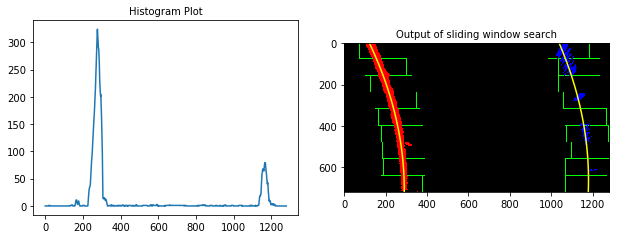

In [326]:
if __DEBUG__ :
    test_image = cv2.imread("test_images//test2.jpg")
    undistorted_test_image = undistort(test_image)
    undistorted_binary_image = lane_filter(undistorted_test_image)
    warped_binary_image = warp_image(undistorted_binary_image)
    histogram, out_img_sliding_window,left_fit,right_fit, left_fitx, right_fitx, ploty= fit_polynomial(warped_binary_image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    ax2.imshow(out_img_sliding_window)
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Output of sliding window search', fontsize=10)    
    ax1.plot(histogram)
    ax1.set_title('Histogram Plot', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #plt.imshow(out_img_sliding_window)
    #plt.plot(histogram)

In [278]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100

    # choosing the activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

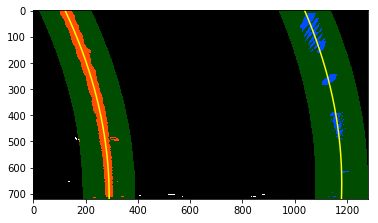

In [289]:
if __DEBUG__:
    out_image_privious_poly = search_around_poly(warped_binary_image,left_fit,right_fit)
    plt.imshow(out_image_privious_poly)

## Measuring the Curvature of the lanes in meters :

In [390]:
def measure_curvature_real(left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

if __DEBUG__:
    print(measure_curvature_real(left_fit,right_fit))

## Shade the lane area

In [399]:
def plot_on_real_frame(undist, warped, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #print(len(warp_zero.shape))
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #print ((color_warp.shape[0]),(color_warp.shape[1]),(color_warp.shape[2]))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.array([pts],dtype = np.int32), [0,255, 0])

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp = unwarp_image(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
    #return (cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
#if __DEBUG__:
#    plt.imshow(plot_on_real_frame(undistorted_test_image, out_image_privious_poly, left_fit,right_fit))

In [421]:
def find_offset(left_base, right_base):
    center_of_lane = int((int(left_base) + int(right_base))/2)
    if center_of_lane > 640:
        side = "left"
        distance = ((center_of_lane-640)*(3.7/700))
    else:
        side = "right"
        distance = ((640-center_of_lane)*(3.7/700))
    return distance,side

Left Lane  : 0.000196587025177 y2 +   -0.439881816862 y +   468.923219431
Right Lane : 5.56038441116e-05 y2 +   -0.252395886628 y +   1328.89326454
(3273.7244581057016, 9841.7474659929303)


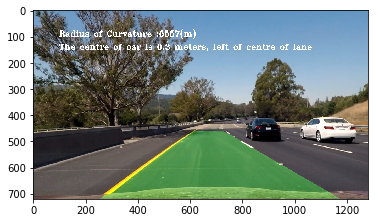

In [425]:
__DEBUG__ = False

def lane_detection_pipeline(image):
    undistorted_image = undistort(image)
    filtered_binary_image = lane_filter(undistorted_image)
    warped_binary_image = warp_image(filtered_binary_image)
    left_fit, right_fit, left_base, right_base = fit_polynomial(warped_binary_image)
    distance, side = find_offset(left_base, right_base)
    #Logic to track the lane from previous frame goes here
    # Logic to check the sanity of plotted lane to be implemented here
    image_with_lanes = plot_on_real_frame(undistorted_image, warped_binary_image, left_fit, right_fit)
    curvature_radius = measure_curvature_real(left_fit, right_fit)
    cv2.putText(image_with_lanes, 
                "Radius of Curvature :"+str((curvature_radius[0]+curvature_radius[1])/2)[:4]+"(m)", 
                (100,100), cv2.FONT_HERSHEY_TRIPLEX, 1, [255,255,255], 2)
    cv2.putText(image_with_lanes, 
            "The centre of car is "+str(distance)[:3]+" meters, "+side+" of centre of lane", 
            (100,150), cv2.FONT_HERSHEY_TRIPLEX, 1, [255,255,255], 2)
    print (measure_curvature_real(left_fit, right_fit))
    return image_with_lanes

plt.imshow((lane_detection_pipeline(plt.imread("test_images//test6.jpg"))))
    

In [417]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [423]:

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    result = lane_detection_pipeline(image)
    # you should return the final output (image where lines are drawn on lanes)

    return result

In [429]:

white_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Left Lane  : -5.19618227249e-05 y2 +   -0.147256600115 y +   512.643812108
Right Lane : 0.000434187053587 y2 +   -0.501131256792 y +   1253.10477488
(9950.648851884238, 1562.7454314585905)
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

Left Lane  : -5.19618227249e-05 y2 +   -0.147256600115 y +   512.643812108
Right Lane : 0.000434187053587 y2 +   -0.501131256792 y +   1253.10477488
(9950.648851884238, 1562.7454314585905)


  0%|▏                                                                                 | 1/485 [00:00<01:36,  5.02it/s]

Left Lane  : 0.00013225866402 y2 +   -0.275542700777 y +   521.046039838
Right Lane : 0.000423455768108 y2 +   -0.488486487323 y +   1249.11241659
(4193.7910247021764, 1580.319163703271)


  0%|▎                                                                                 | 2/485 [00:00<01:37,  4.94it/s]

Left Lane  : 4.26617437965e-05 y2 +   -0.162443665462 y +   488.826965443
Right Lane : 0.000368856600471 y2 +   -0.426497183244 y +   1231.53252109
(12172.381735642555, 1701.3062216947931)


  1%|▌                                                                                 | 3/485 [00:00<01:38,  4.90it/s]

Left Lane  : 0.000160468322636 y2 +   -0.292582623995 y +   519.60575506
Right Lane : 0.00026923726702 y2 +   -0.331708082497 y +   1212.56892043
(3497.5106639664718, 2141.3124872127855)


  1%|▋                                                                                 | 4/485 [00:00<01:40,  4.79it/s]

Left Lane  : -0.000284708006211 y2 +   0.0160088183036 y +   477.013404284
Right Lane : 0.000276069507777 y2 +   -0.338390321498 y +   1212.34100575
(1756.1881502019792, 2099.7198617914455)


  1%|▊                                                                                 | 5/485 [00:01<01:39,  4.83it/s]

Left Lane  : -0.00018637082755 y2 +   -0.139597442539 y +   535.238213969
Right Lane : 0.000332894222993 y2 +   -0.395024806178 y +   1227.05748435
(2774.8113165004124, 1829.8347526280918)


  1%|█                                                                                 | 6/485 [00:01<01:39,  4.81it/s]

Left Lane  : 0.00215113121957 y2 +   -2.70224286446 y +   830.129527631
Right Lane : 0.000263927806186 y2 +   -0.323326585731 y +   1208.29492751
(4891.2461379297638, 2169.4353385439231)


  1%|█▏                                                                                | 7/485 [00:01<01:37,  4.88it/s]

Left Lane  : 0.00129811847741 y2 +   -2.08819591716 y +   725.013771461
Right Lane : 0.000299092535863 y2 +   -0.367261987846 y +   1223.20371396
(4360.4473917723162, 1986.9026184569891)


  2%|█▎                                                                                | 8/485 [00:01<01:36,  4.94it/s]

Left Lane  : 0.00238440726207 y2 +   -2.96109718109 y +   906.049984418
Right Lane : 0.000218362516407 y2 +   -0.284574715031 y +   1203.87905973
(5607.5451857536445, 2547.5391326156919)


  2%|█▌                                                                                | 9/485 [00:01<01:37,  4.89it/s]

Left Lane  : 0.00312148273983 y2 +   -3.41124668397 y +   975.577496119
Right Lane : 0.000224003516198 y2 +   -0.275287107047 y +   1199.48672798
(6161.8874011845928, 2465.5954104431407)


  2%|█▋                                                                               | 10/485 [00:02<01:38,  4.82it/s]

Left Lane  : 0.00177718636534 y2 +   -2.44350984963 y +   796.38064511
Right Lane : 7.55527366363e-05 y2 +   -0.125224660662 y +   1166.32750959
(4621.2197858771206, 6763.0331706790002)


  2%|█▊                                                                               | 11/485 [00:02<01:37,  4.86it/s]

Left Lane  : 0.00207616497866 y2 +   -2.63459547097 y +   815.671462134
Right Lane : 9.93732700425e-05 y2 +   -0.164745498435 y +   1184.76150303
(4751.0578189197677, 5223.0317070272513)


  2%|██                                                                               | 12/485 [00:02<01:37,  4.86it/s]

Left Lane  : 0.00191084440665 y2 +   -2.46567541616 y +   773.291437104
Right Lane : -0.000164522442102 y2 +   0.116622895901 y +   1113.29120785
(4364.3693650323712, 3091.210082737975)


  3%|██▏                                                                              | 13/485 [00:02<01:35,  4.96it/s]

Left Lane  : 0.00192140779043 y2 +   -2.47585707279 y +   770.266177895
Right Lane : -0.000282244862936 y2 +   0.237891557664 y +   1085.75127928
(4385.3246657775471, 1902.8434415001932)


  3%|██▎                                                                              | 14/485 [00:02<01:35,  4.91it/s]

Left Lane  : 0.00214815817652 y2 +   -2.64375450341 y +   798.551829414
Right Lane : -0.000145056438731 y2 +   0.0881600107031 y +   1125.94534293
(4614.8213656202852, 3479.6382136553793)


  3%|██▌                                                                              | 15/485 [00:03<01:39,  4.71it/s]

Left Lane  : 0.00136652445658 y2 +   -2.09041274488 y +   704.48229451
Right Lane : -0.000353539415598 y2 +   0.337248959463 y +   1055.21781409
(4132.8537428278833, 1631.4006694595294)


  3%|██▋                                                                              | 16/485 [00:03<01:38,  4.75it/s]

Left Lane  : 0.00130571311244 y2 +   -2.0163489061 y +   681.652323748
Right Lane : -0.000373251083624 y2 +   0.378253701038 y +   1040.41188694
(3972.1410060726471, 1601.9789287603462)


  4%|██▊                                                                              | 17/485 [00:03<01:38,  4.75it/s]

Left Lane  : 0.00139781980808 y2 +   -2.14754421297 y +   729.380624094
Right Lane : -0.000449777378928 y2 +   0.48670357895 y +   998.680843525
(4314.2243748859055, 1482.1420680269164)


  4%|███                                                                              | 18/485 [00:03<01:37,  4.79it/s]

Left Lane  : -3.08196394117e-05 y2 +   -1.16041526812 y +   556.012225336
Right Lane : -0.000996129256163 y2 +   1.1402066735 y +   809.048759927
(58476.3922552808, 1601.7741290405681)


  4%|███▏                                                                             | 19/485 [00:03<01:38,  4.72it/s]

Left Lane  : 0.000453827373439 y2 +   -1.49567044175 y +   619.571365978
Right Lane : -0.000663742154042 y2 +   0.809802301032 y +   885.50541703
(6178.3633750216759, 1514.5171960988484)


  4%|███▎                                                                             | 20/485 [00:04<01:39,  4.66it/s]

Left Lane  : 0.000826058489772 y2 +   -1.71621114159 y +   646.357510116
Right Lane : -0.000319188962765 y2 +   0.428588718997 y +   992.36758242
(4444.6999048644211, 1976.5015647458233)


  4%|███▌                                                                             | 21/485 [00:04<01:45,  4.39it/s]

Left Lane  : 0.00204241007396 y2 +   -2.60685727254 y +   811.753260628
Right Lane : -0.000361690960383 y2 +   0.471185699952 y +   979.13826249
(4702.6968635061712, 1821.8947817796163)


  5%|███▋                                                                             | 22/485 [00:04<01:48,  4.28it/s]

Left Lane  : 0.00179606617865 y2 +   -2.37389212031 y +   750.591962744
Right Lane : -0.000176625272025 y2 +   0.266652668622 y +   1038.88026295
(4231.3339834563367, 3113.8036649811243)


  5%|███▊                                                                             | 23/485 [00:04<01:43,  4.45it/s]

Left Lane  : 0.00141882930762 y2 +   -2.13687824275 y +   729.794085439
Right Lane : -0.000209038784078 y2 +   0.311467487883 y +   1018.44933131
(4190.984683166781, 2719.5951443000286)


  5%|████                                                                             | 24/485 [00:05<01:39,  4.64it/s]

Left Lane  : 0.00158818043282 y2 +   -2.28518246512 y +   770.075733941
Right Lane : -0.000221008588144 y2 +   0.304200335019 y +   1026.66585035
(4393.2485719087217, 2555.637819939273)


  5%|████▏                                                                            | 25/485 [00:05<01:36,  4.74it/s]

Left Lane  : 0.00241558127598 y2 +   -2.92404231479 y +   917.430554141
Right Lane : -0.000341801058317 y2 +   0.417077030758 y +   997.399879647
(5334.1279670005879, 1821.2083876495162)


  5%|████▎                                                                            | 26/485 [00:05<01:35,  4.82it/s]

Left Lane  : 0.00159353655857 y2 +   -2.34276021603 y +   815.975506791
Right Lane : -0.000259881679975 y2 +   0.369443608375 y +   996.536569213
(4669.4983064315275, 2296.4329743426842)


  6%|████▌                                                                            | 27/485 [00:05<01:35,  4.78it/s]

Left Lane  : 0.00245619520827 y2 +   -2.96943292753 y +   941.079284288
Right Lane : -0.000443565926875 y2 +   0.563003551857 y +   944.015342056
(5464.4441766111941, 1647.2552933639693)


  6%|████▋                                                                            | 28/485 [00:05<01:36,  4.76it/s]

Left Lane  : 0.00114874619951 y2 +   -2.067002519 y +   792.406805627
Right Lane : -0.000616657219837 y2 +   0.731074415786 y +   908.676695383
(4855.6655227638494, 1462.5663908085392)


  6%|████▊                                                                            | 29/485 [00:06<01:36,  4.73it/s]

Left Lane  : 0.00164475781588 y2 +   -2.44424192343 y +   862.375975244
Right Lane : -0.00106039993743 y2 +   1.19511068584 y +   797.893659348
(5040.415676411104, 1623.8077188955037)


  6%|█████                                                                            | 30/485 [00:06<01:33,  4.88it/s]

Left Lane  : 0.00337748112767 y2 +   -3.63121101724 y +   1063.11116974
Right Lane : -0.00148584308284 y2 +   1.56026892333 y +   747.149479837
(6745.2538248566198, 1894.3739749892127)


  6%|█████▏                                                                           | 31/485 [00:06<01:31,  4.96it/s]

Left Lane  : 0.00218856543811 y2 +   -2.80981894463 y +   925.73420277
Right Lane : -0.0011788742974 y2 +   1.15672162594 y +   884.02318521
(5340.3692797398826, 1364.7826004543676)


  7%|█████▎                                                                           | 32/485 [00:06<01:30,  5.02it/s]

Left Lane  : 0.00255806078912 y2 +   -3.05193533407 y +   968.600149215
Right Lane : -0.000961740158011 y2 +   0.851213047514 y +   997.111522583
(5635.1747352095172, 1081.7004028213826)


  7%|█████▌                                                                           | 33/485 [00:06<01:29,  5.04it/s]

Left Lane  : 0.00341724404343 y2 +   -3.655669141 y +   1073.42690069
Right Lane : -0.00155441477411 y2 +   1.71123526462 y +   696.412182027
(6786.1745760715057, 2213.8615824811623)


  7%|█████▋                                                                           | 34/485 [00:07<01:33,  4.84it/s]

Left Lane  : 0.00348502733326 y2 +   -3.75281330338 y +   1103.16916472
Right Lane : -0.000840422128391 y2 +   0.821058934498 y +   985.368136906
(7163.9242392770157, 1197.2876546070718)


  7%|█████▊                                                                           | 35/485 [00:07<01:35,  4.70it/s]

Left Lane  : 0.00371251547381 y2 +   -4.07662787488 y +   1207.49134953
Right Lane : 0.00099297154625 y2 +   -1.22863089426 y +   1556.25230606
(8502.388009798311, 1833.5673310107759)


  7%|██████                                                                           | 36/485 [00:07<01:38,  4.55it/s]

Left Lane  : 0.0029541307239 y2 +   -3.64007468957 y +   1167.48568495
Right Lane : -0.000519282554631 y2 +   0.575678677591 y +   1025.3276963
(7926.8049812292375, 1421.5125455997872)


  8%|██████▏                                                                          | 37/485 [00:07<01:37,  4.59it/s]

Left Lane  : 0.00392578736468 y2 +   -4.20477839195 y +   1252.37199571
Right Lane : 0.000842598886405 y2 +   -1.11943240931 y +   1545.91504509
(8736.8105278203748, 1861.1229900550875)


  8%|██████▎                                                                          | 38/485 [00:08<01:38,  4.56it/s]

Left Lane  : 0.00435088373709 y2 +   -4.41930060657 y +   1273.96236557
Right Lane : 0.000734615593825 y2 +   -1.00269518929 y +   1522.28782009
(8992.0125952148283, 1809.4427212245407)


  8%|██████▌                                                                          | 39/485 [00:08<01:37,  4.56it/s]

Left Lane  : 0.00418967085456 y2 +   -4.33947953749 y +   1267.97818631
Right Lane : 0.000549779597696 y2 +   -0.795722032055 y +   1468.08358721
(8898.5025669610586, 1809.3523159609745)


  8%|██████▋                                                                          | 40/485 [00:08<01:36,  4.59it/s]

Left Lane  : 0.0036712613197 y2 +   -3.83859557955 y +   1144.69949314
Right Lane : 0.00110630890158 y2 +   -1.47313021817 y +   1680.32109094
(7206.5439994560857, 2324.0486012326469)


  8%|██████▊                                                                          | 41/485 [00:08<01:33,  4.74it/s]

Left Lane  : 0.0035881341766 y2 +   -3.79535532597 y +   1143.21789819
Right Lane : 0.000859589810913 y2 +   -0.829715065495 y +   1232.28179388
(7158.4224910775765, 1183.4229709648405)


  9%|███████                                                                          | 42/485 [00:08<01:32,  4.81it/s]

Left Lane  : 0.00356194660945 y2 +   -3.78481872696 y +   1163.62106903
Right Lane : 0.00102711209586 y2 +   -0.973432250321 y +   1254.70085837
(7160.9103811462164, 1206.6427186972544)


  9%|███████▏                                                                         | 43/485 [00:09<01:34,  4.70it/s]

Left Lane  : 0.00376399872219 y2 +   -4.04856810575 y +   1240.37487841
Right Lane : 0.00101001087023 y2 +   -0.984903906944 y +   1262.45178153
(8197.106809394385, 1250.2056006998496)


  9%|███████▎                                                                         | 44/485 [00:09<01:31,  4.85it/s]

Left Lane  : 0.00398366917107 y2 +   -4.29479751397 y +   1321.7940189
Right Lane : 0.000830075948608 y2 +   -0.839427137932 y +   1232.38277034
(9150.7228641982765, 1246.1662370583026)


  9%|███████▌                                                                         | 45/485 [00:09<01:29,  4.91it/s]

Left Lane  : 0.0038181305194 y2 +   -4.24316309928 y +   1314.94903679
Right Lane : 0.000827666191668 y2 +   -0.857591359663 y +   1243.2126483
(9272.5266740676288, 1283.7211581709448)


  9%|███████▋                                                                         | 46/485 [00:09<01:29,  4.90it/s]

Left Lane  : 0.000122418297649 y2 +   -1.35198230712 y +   758.226424408
Right Lane : 0.000584264761884 y2 +   -0.624588138545 y +   1194.90251417
(19219.279735522661, 1338.7656564090273)


 10%|███████▊                                                                         | 47/485 [00:09<01:28,  4.97it/s]

Left Lane  : 0.00296308197673 y2 +   -3.62606492853 y +   1208.20616904
Right Lane : 0.000640941668516 y2 +   -0.69800245636 y +   1215.92288538
(7811.309799458174, 1341.1017471530067)


 10%|████████                                                                         | 48/485 [00:10<01:27,  5.02it/s]

Left Lane  : 0.000326267811814 y2 +   -1.54201273352 y +   820.800562534
Right Lane : 0.000684183195909 y2 +   -0.754125738855 y +   1230.9068034
(9261.6841007299608, 1354.0669841334043)


 10%|████████▏                                                                        | 49/485 [00:10<01:28,  4.95it/s]

Left Lane  : 0.00357205330126 y2 +   -3.98818311266 y +   1284.85675132
Right Lane : 0.000910200940845 y2 +   -0.989796520087 y +   1284.33303046
(8331.2818849656323, 1410.0499991043148)


 10%|████████▎                                                                        | 50/485 [00:10<01:27,  4.98it/s]

Left Lane  : 0.00204355203288 y2 +   -2.84657944992 y +   1086.16730951
Right Lane : 0.0011524175261 y2 +   -1.18260656368 y +   1318.64695578
(5978.9324003548691, 1454.571938408003)


 11%|████████▌                                                                        | 51/485 [00:10<01:26,  5.03it/s]

Left Lane  : 0.00400010403431 y2 +   -4.44296737073 y +   1416.39990513
Right Lane : 0.0011738399704 y2 +   -1.21851908069 y +   1330.48387829
(10081.714461773347, 1503.5733663117139)


 11%|████████▋                                                                        | 52/485 [00:10<01:28,  4.90it/s]

Left Lane  : 0.002744072551 y2 +   -3.31387539859 y +   1179.78227811
Right Lane : 0.00113157293832 y2 +   -1.21712429531 y +   1338.40399023
(6574.3749937668799, 1562.3741664520942)


 11%|████████▊                                                                        | 53/485 [00:11<01:31,  4.71it/s]

Left Lane  : 0.00143964646932 y2 +   -2.26592192108 y +   955.517648696
Right Lane : 0.00116036273358 y2 +   -1.2380054139 y +   1348.21591904
(4789.8444611678606, 1567.5389355219568)


 11%|█████████                                                                        | 54/485 [00:11<01:32,  4.66it/s]

Left Lane  : 0.000350328605982 y2 +   -1.53573798115 y +   846.579389129
Right Lane : 0.00121043584531 y2 +   -1.29047319149 y +   1362.4466315
(8534.3556045673504, 1616.5810584899086)


 11%|█████████▏                                                                       | 55/485 [00:11<01:30,  4.76it/s]

Left Lane  : 0.000395695542323 y2 +   -1.5773853997 y +   864.701406973
Right Lane : -0.000121820480294 y2 +   0.0651647487824 y +   1273.90354346
(7970.5292420775986, 4125.0323987938191)


 12%|█████████▎                                                                       | 56/485 [00:11<01:29,  4.78it/s]

Left Lane  : 0.00342418160195 y2 +   -3.63306919934 y +   1218.22330515
Right Lane : 0.00136122195099 y2 +   -1.50810732865 y +   1428.88098456
(6648.2177588104041, 1942.1697158956574)


 12%|█████████▌                                                                       | 57/485 [00:11<01:27,  4.87it/s]

Left Lane  : 0.00535857633646 y2 +   -4.38579331196 y +   1265.27609588
Right Lane : 0.00101562531918 y2 +   -1.20400245493 y +   1366.23397378
(6843.7759637273357, 1724.8401040862402)


 12%|█████████▋                                                                       | 58/485 [00:12<01:27,  4.90it/s]

Left Lane  : 0.00517085465558 y2 +   -4.48352341143 y +   1320.5205964
Right Lane : 0.00100291139551 y2 +   -1.20780979031 y +   1370.18265541
(7644.2509257712027, 1758.6081139294381)


 12%|█████████▊                                                                       | 59/485 [00:12<01:25,  4.96it/s]

Left Lane  : 0.00498909268734 y2 +   -4.33479830747 y +   1290.50870897
Right Lane : 0.0009571284043 y2 +   -1.17637156199 y +   1369.74629567
(7204.0115788621988, 1765.6891132869382)


 12%|██████████                                                                       | 60/485 [00:12<01:25,  4.96it/s]

Left Lane  : 0.00418261407785 y2 +   -3.81905577035 y +   1200.73923919
Right Lane : 0.000860756219349 y2 +   -1.08600356759 y +   1355.11129203
(6084.2788842821792, 1730.0537616239012)


 13%|██████████▏                                                                      | 61/485 [00:12<01:25,  4.93it/s]

Left Lane  : 0.00266739020004 y2 +   -2.63268062981 y +   973.656858228
Right Lane : 0.000874744778569 y2 +   -1.11408557325 y +   1368.97744861
(3557.5329615576716, 1773.3162468551136)


 13%|██████████▎                                                                      | 62/485 [00:12<01:27,  4.85it/s]

Left Lane  : 0.00247435849467 y2 +   -2.6813864227 y +   1011.80706331
Right Lane : 0.00105464436595 y2 +   -1.26233718248 y +   1398.62973631
(4081.5782341490285, 1804.6863020340263)


 13%|██████████▌                                                                      | 63/485 [00:13<01:26,  4.88it/s]

Left Lane  : 0.0031210412116 y2 +   -3.17217926712 y +   1108.92921337
Right Lane : 0.00159933182275 y2 +   -1.74363471803 y +   1499.99002329
(4998.7933758523495, 2238.8101020680197)


 13%|██████████▋                                                                      | 64/485 [00:13<01:25,  4.92it/s]

Left Lane  : 0.00330547807692 y2 +   -3.42021016237 y +   1173.62501247
Right Lane : 0.00147456714512 y2 +   -1.64402303837 y +   1482.89262207
(5808.7207252714388, 2144.6998472419832)


 13%|██████████▊                                                                      | 65/485 [00:13<01:24,  5.00it/s]

Left Lane  : 0.00309940330609 y2 +   -3.29165210013 y +   1168.43318201
Right Lane : 0.00132295725506 y2 +   -1.52669357545 y +   1462.11485243
(5604.3697376768869, 2057.8999336431616)


 14%|███████████                                                                      | 66/485 [00:13<01:23,  4.99it/s]

Left Lane  : 0.0013739172669 y2 +   -1.19107519399 y +   795.945982024
Right Lane : 0.00130251972894 y2 +   -1.56899694677 y +   1485.54030439
(1211.359285222286, 2221.0840008168143)


 14%|███████████▏                                                                     | 67/485 [00:13<01:22,  5.04it/s]

Left Lane  : 0.00226941507745 y2 +   -2.62229019459 y +   1062.12722481
Right Lane : 0.000855921635524 y2 +   -1.16721718523 y +   1402.04670802
(4240.356198926851, 1965.3937806584254)


 14%|███████████▎                                                                     | 68/485 [00:14<01:22,  5.06it/s]

Left Lane  : 0.00211002076346 y2 +   -2.57158714294 y +   1078.70205581
Right Lane : 0.00094972980848 y2 +   -1.27664272425 y +   1433.31511081
(4368.7368701466958, 2065.7745074409909)


 14%|███████████▌                                                                     | 69/485 [00:14<01:21,  5.09it/s]

Left Lane  : 0.00207779836053 y2 +   -2.49951826435 y +   1056.55425387
Right Lane : 0.00109077658163 y2 +   -1.4147659337 y +   1469.16884897
(4118.0441208918919, 2171.7887534240422)


 14%|███████████▋                                                                     | 70/485 [00:14<01:21,  5.07it/s]

Left Lane  : 0.00191018000724 y2 +   -2.38983985777 y +   1040.19805063
Right Lane : 0.00128479958707 y2 +   -1.58648242382 y +   1507.95234804
(4018.8649548678113, 2310.2886230538334)


 15%|███████████▊                                                                     | 71/485 [00:14<01:20,  5.11it/s]

Left Lane  : 0.00100937731688 y2 +   -1.70966343578 y +   909.519510856
Right Lane : 0.00087314886246 y2 +   -1.24915433361 y +   1455.47272
(3553.8390298650243, 2172.4009621554465)


 15%|████████████                                                                     | 72/485 [00:14<01:22,  4.99it/s]

Left Lane  : 0.00133584704125 y2 +   -1.89879728809 y +   933.039122538
Right Lane : 0.00105479469099 y2 +   -1.45651121797 y +   1512.33568724
(3346.6373195909091, 2391.1937399260719)


 15%|████████████▏                                                                    | 73/485 [00:15<01:21,  5.06it/s]

Left Lane  : 0.00124753722962 y2 +   -1.80946961409 y +   907.464369985
Right Lane : 0.00111384100528 y2 +   -1.54749917627 y +   1548.75827635
(3217.4552690769042, 2560.7945268675289)


 15%|████████████▎                                                                    | 74/485 [00:15<01:22,  4.98it/s]

Left Lane  : 0.00125972676822 y2 +   -1.82417946823 y +   911.035368899
Right Lane : 0.000804208699401 y2 +   -1.19427554809 y +   1452.27655195
(3244.5496650652999, 2187.8210541879089)


 15%|████████████▌                                                                    | 75/485 [00:15<01:22,  4.96it/s]

Left Lane  : 0.00104323959905 y2 +   -1.70031129216 y +   895.982163218
Right Lane : 0.000786973799362 y2 +   -1.18153783114 y +   1452.22244325
(3386.7461203148378, 2197.1532540580815)


 16%|████████████▋                                                                    | 76/485 [00:15<01:22,  4.99it/s]

Left Lane  : 0.00110931330038 y2 +   -1.72208332069 y +   893.380040385
Right Lane : 0.000770721724525 y2 +   -1.13045073868 y +   1436.79333639
(3261.4378491345315, 2081.8741090008211)


 16%|████████████▊                                                                    | 77/485 [00:15<01:20,  5.05it/s]

Left Lane  : 0.00109460685808 y2 +   -1.71579103709 y +   893.65655201
Right Lane : 0.00141940604176 y2 +   -1.70843125738 y +   1560.7153138
(3281.578296603102, 2441.6756640520548)


 16%|█████████████                                                                    | 78/485 [00:16<01:19,  5.10it/s]

Left Lane  : 0.000964280174681 y2 +   -1.64231500699 y +   892.423690448
Right Lane : 0.00171659708198 y2 +   -1.9911367577 y +   1624.64890847
(3410.8995445165292, 2841.520303492237)


 16%|█████████████▏                                                                   | 79/485 [00:16<01:19,  5.08it/s]

Left Lane  : 0.0012391340299 y2 +   -1.85842593565 y +   933.473791817
Right Lane : 0.000595335336148 y2 +   -1.04345743661 y +   1438.82342879
(3452.4755287577482, 2403.3997717733846)


 16%|█████████████▎                                                                   | 80/485 [00:16<01:19,  5.08it/s]

Left Lane  : 0.000840675413852 y2 +   -1.62592807435 y +   911.489223851
Right Lane : 0.00057000053872 y2 +   -1.00314174347 y +   1425.99519768
(3865.0598990531334, 2368.3251348929061)


 17%|█████████████▌                                                                   | 81/485 [00:16<01:20,  5.04it/s]

Left Lane  : 0.00078019445426 y2 +   -1.51642504266 y +   863.385458458
Right Lane : 0.00043398748809 y2 +   -0.860130353707 y +   1398.06664109
(3599.8831553951914, 2544.1491325892139)


 17%|█████████████▋                                                                   | 82/485 [00:16<01:20,  5.04it/s]

Left Lane  : 0.000424529140463 y2 +   -1.2811413843 y +   823.667454936
Right Lane : 0.000998980874949 y2 +   -1.39314346849 y +   1521.64001103
(4871.7200280345787, 2317.024593742633)


 17%|█████████████▊                                                                   | 83/485 [00:17<01:19,  5.05it/s]

Left Lane  : 0.000301058664172 y2 +   -1.20364826673 y +   810.69541977
Right Lane : 0.000210103558169 y2 +   -0.613486322737 y +   1339.39711431
(6196.8807233593179, 3778.8625291756966)


 17%|██████████████                                                                   | 84/485 [00:17<01:20,  5.00it/s]

Left Lane  : 0.000373960222657 y2 +   -1.24901425244 y +   819.281997373
Right Lane : 0.00143298516949 y2 +   -1.8533867257 y +   1643.03214986
(5299.6049607701107, 2922.3368385928675)


 18%|██████████████▏                                                                  | 85/485 [00:17<01:19,  5.05it/s]

Left Lane  : 0.000399086259225 y2 +   -1.25768958774 y +   820.828593521
Right Lane : 0.00128571393762 y2 +   -1.72205995416 y +   1616.76067281
(5018.5055234136962, 2774.6116133116116)


 18%|██████████████▎                                                                  | 86/485 [00:17<01:19,  5.03it/s]

Left Lane  : 0.000492234725393 y2 +   -1.34190231036 y +   851.239551567
Right Lane : -0.000511511393647 y2 +   0.0261684042186 y +   1238.28217271
(4562.7846778197299, 977.52475654889906)


 18%|██████████████▌                                                                  | 87/485 [00:17<01:19,  4.98it/s]

Left Lane  : 0.000720425749378 y2 +   -1.47948225519 y +   877.645173568
Right Lane : -0.000215848533242 y2 +   -0.0386391199058 y +   1161.70720407
(3720.5102459766185, 2325.6867909036259)


 18%|██████████████▋                                                                  | 88/485 [00:18<01:19,  4.98it/s]

Left Lane  : 0.00111513424813 y2 +   -1.70973964773 y +   910.103713392
Right Lane : -0.000274244644825 y2 +   0.0291673682582 y +   1140.11947107
(3190.1032646147373, 1823.6332410376194)


 18%|██████████████▊                                                                  | 89/485 [00:18<01:19,  4.96it/s]

Left Lane  : 0.00105655623972 y2 +   -1.63086827256 y +   879.737863615
Right Lane : -0.000239567250601 y2 +   -0.0436437572288 y +   1174.78455521
(3042.1052712343039, 2097.6361758324751)


 19%|███████████████                                                                  | 90/485 [00:18<01:19,  4.94it/s]

Left Lane  : 0.00118153000715 y2 +   -1.74971558241 y +   906.577489406
Right Lane : -0.000141198158902 y2 +   -0.152012937564 y +   1207.1053387
(3158.0004683431657, 3678.7838988196877)


 19%|███████████████▏                                                                 | 91/485 [00:18<01:20,  4.87it/s]

Left Lane  : 0.000866753749098 y2 +   -1.55735792322 y +   878.473041563
Right Lane : -1.42962557445e-05 y2 +   -0.164218894802 y +   1173.52794636
(3405.3301386562503, 36413.453159172816)


 19%|███████████████▎                                                                 | 92/485 [00:18<01:25,  4.57it/s]

Left Lane  : 0.00119778206286 y2 +   -1.73154643624 y +   889.568051599
Right Lane : 0.000174561319276 y2 +   -0.268069501137 y +   1169.06441298
(3037.274957549434, 3154.1304627599488)


 19%|███████████████▌                                                                 | 93/485 [00:19<01:29,  4.38it/s]

Left Lane  : 0.000794858284712 y2 +   -1.47060204977 y +   842.653527527
Right Lane : -0.000826406015861 y2 +   0.299735625635 y +   1169.18879691
(3309.3206730158058, 662.73125446544373)


 19%|███████████████▋                                                                 | 94/485 [00:19<01:32,  4.21it/s]

Left Lane  : 0.000929408851565 y2 +   -1.59001353626 y +   876.72282698
Right Lane : -0.000270844790869 y2 +   -0.0599343179473 y +   1197.30599876
(3304.7484785039119, 1862.1618630097316)


 20%|███████████████▊                                                                 | 95/485 [00:19<01:34,  4.11it/s]

Left Lane  : 0.00109994391563 y2 +   -1.7421184569 y +   913.126485007
Right Lane : -0.00049381924389 y2 +   0.155120892845 y +   1155.50388661
(3380.136203026675, 1036.5438904049797)


 20%|████████████████                                                                 | 96/485 [00:20<01:37,  4.00it/s]

Left Lane  : 0.00108290049315 y2 +   -1.82806250325 y +   972.498071504
Right Lane : -0.000876034350266 y2 +   0.477313398276 y +   1092.01733591
(3845.5089484210644, 732.03940114848376)


 20%|████████████████▏                                                                | 97/485 [00:20<01:31,  4.24it/s]

Left Lane  : 0.00157924423459 y2 +   -2.20869376317 y +   1049.88053981
Right Lane : -0.00142707594425 y2 +   0.917576819419 y +   1016.23231775
(4049.6521902064887, 771.35676792766537)


 20%|████████████████▎                                                                | 98/485 [00:20<01:27,  4.43it/s]

Left Lane  : 0.00198657544775 y2 +   -2.56911350567 y +   1138.52062177
Right Lane : -0.000292902417591 y2 +   -0.139842224312 y +   1242.42512245
(4664.2642563978197, 1770.8756638044063)


 20%|████████████████▌                                                                | 99/485 [00:20<01:22,  4.65it/s]

Left Lane  : 0.00216214917653 y2 +   -2.70437599286 y +   1156.56190079
Right Lane : -0.000185937654271 y2 +   -0.202855198607 y +   1246.92655663
(4873.5850519701744, 2875.8885049290011)


 21%|████████████████▍                                                               | 100/485 [00:20<01:20,  4.78it/s]

Left Lane  : 0.00234024685588 y2 +   -2.75199853891 y +   1131.65164024
Right Lane : -0.000212989747848 y2 +   -0.157851623881 y +   1236.99192979
(4673.4123194024742, 2450.7741799787323)


 21%|████████████████▋                                                               | 101/485 [00:20<01:18,  4.91it/s]

Left Lane  : 0.00255768584981 y2 +   -2.91394012099 y +   1145.65725945
Right Lane : -8.91472876365e-06 y2 +   -0.342125325145 y +   1274.19679102
(4948.6994403674835, 66249.699523125018)


 21%|████████████████▊                                                               | 102/485 [00:21<01:17,  4.95it/s]

Left Lane  : 0.00198283515736 y2 +   -2.48502220361 y +   1061.5490863
Right Lane : -0.000314854696201 y2 +   -0.0392372265272 y +   1218.53595065
(4274.6351398187271, 1596.0824058859303)


 21%|████████████████▉                                                               | 103/485 [00:21<01:16,  5.00it/s]

Left Lane  : 0.00232243972785 y2 +   -2.67246040446 y +   1063.27387386
Right Lane : -0.000283352770563 y2 +   -0.0893534147788 y +   1232.2996046
(4349.3545399358118, 1794.5955799107587)


 21%|█████████████████▏                                                              | 104/485 [00:21<01:17,  4.94it/s]

Left Lane  : 0.00215862177496 y2 +   -2.62702464807 y +   1064.60854305
Right Lane : 0.000274029865705 y2 +   -0.47470439548 y +   1281.65138487
(4510.8776980219891, 2428.6443090421253)


 22%|█████████████████▎                                                              | 105/485 [00:21<01:16,  4.96it/s]

Left Lane  : 0.00235022000973 y2 +   -2.7436081598 y +   1079.31598527
Right Lane : 4.51235800357e-05 y2 +   -0.369924968674 y +   1275.7089223
(4611.8148450407898, 13395.995904235717)


 22%|█████████████████▍                                                              | 106/485 [00:21<01:15,  5.03it/s]

Left Lane  : 0.00219804895948 y2 +   -2.67732244903 y +   1076.01439217
Right Lane : -0.00147234806387 y2 +   0.938236364365 y +   1011.96994572
(4653.738843281757, 767.73271383101883)


 22%|█████████████████▋                                                              | 107/485 [00:22<01:14,  5.04it/s]

Left Lane  : 0.00165075041598 y2 +   -2.33813915495 y +   1035.42512274
Right Lane : -0.000862950933216 y2 +   0.432575562201 y +   1104.63726664
(4467.3594839076795, 709.94967088790804)


 22%|█████████████████▊                                                              | 108/485 [00:22<01:14,  5.07it/s]

Left Lane  : 0.0020258492057 y2 +   -2.75571177643 y +   1152.40526669
Right Lane : 7.75117689244e-05 y2 +   -0.376326652023 y +   1262.23554763
(5521.6443165482224, 7832.4991592052638)


 22%|█████████████████▉                                                              | 109/485 [00:22<01:13,  5.09it/s]

Left Lane  : 0.00180819492236 y2 +   -2.60642175532 y +   1137.46976168
Right Lane : -0.00148455056142 y2 +   1.09387701107 y +   931.255614061
(5387.2764755759299, 959.68806575289511)


 23%|██████████████████▏                                                             | 110/485 [00:22<01:13,  5.11it/s]

Left Lane  : 0.00226128776823 y2 +   -3.10014885604 y +   1273.29162877
Right Lane : -0.00386286699825 y2 +   3.58579785785 y +   306.164590788
(6772.2904904803008, 5550.7549741898638)


 23%|██████████████████▎                                                             | 111/485 [00:22<01:12,  5.17it/s]

Left Lane  : 0.00260169189457 y2 +   -3.44293304204 y +   1356.54296297
Right Lane : -0.00374788228877 y2 +   3.5236836813 y +   315.984059963
(7794.6360504549884, 5465.6233910429146)


 23%|██████████████████▍                                                             | 112/485 [00:23<01:12,  5.17it/s]

Left Lane  : 0.00302781441005 y2 +   -3.97114592663 y +   1522.095443
Right Lane : -0.000180348432269 y2 +   -0.0177145886129 y +   1140.83673204
(9942.9318381302601, 2775.79450210505)


 23%|██████████████████▋                                                             | 113/485 [00:23<01:12,  5.10it/s]

Left Lane  : 0.00537983978214 y2 +   -5.91516136662 y +   1918.41152079
Right Lane : -0.00151596598723 y2 +   1.41058321199 y +   787.037062547
(17044.859994311926, 1497.3418287217755)


 24%|██████████████████▊                                                             | 114/485 [00:23<01:13,  5.02it/s]

Left Lane  : 0.00283218088499 y2 +   -3.87092917636 y +   1518.92392884
Right Lane : -0.000712514394899 y2 +   0.599739299557 y +   980.876623973
(9949.166816346853, 1052.5278572164552)


 24%|██████████████████▉                                                             | 115/485 [00:23<01:13,  5.06it/s]

Left Lane  : 0.00510984254403 y2 +   -6.16326954106 y +   2090.34694173
Right Lane : -0.00104431663082 y2 +   0.967807729281 y +   888.700416391
(20527.180309861236, 1175.029133018927)


 24%|███████████████████▏                                                            | 116/485 [00:23<01:12,  5.11it/s]

Left Lane  : 0.00299507169496 y2 +   -4.15775052154 y +   1630.50287214
Right Lane : 7.6115656583e-05 y2 +   -0.169440597995 y +   1147.36520384
(11523.025800044416, 6838.6326058309523)


 24%|███████████████████▎                                                            | 117/485 [00:24<01:11,  5.13it/s]

Left Lane  : 0.00726375878601 y2 +   -8.54531900265 y +   2770.75095324
Right Lane : 1.95223745859e-05 y2 +   -0.0405770983259 y +   1102.15796189
(37559.238285903695, 25671.321704118185)


 24%|███████████████████▍                                                            | 118/485 [00:24<01:11,  5.16it/s]

Left Lane  : 0.003478143304 y2 +   -4.28068937984 y +   1652.19178907
Right Lane : 0.00010786075051 y2 +   -0.0742382127801 y +   1091.62819597
(10599.427510500349, 4667.5838564606038)


 25%|███████████████████▋                                                            | 119/485 [00:24<01:12,  5.05it/s]

Left Lane  : 0.00746120775035 y2 +   -9.64525919946 y +   3338.33354758
Right Lane : 0.00019309057106 y2 +   -0.108039375223 y +   1074.90696148
(53079.288196185415, 2625.6904303208598)


 25%|███████████████████▊                                                            | 120/485 [00:24<01:14,  4.89it/s]

Left Lane  : 0.00441185063534 y2 +   -5.55797580131 y +   2081.48799719
Right Lane : 0.000349079659556 y2 +   -0.193757746904 y +   1071.57965275
(17719.539239773054, 1497.0001372872907)


 25%|███████████████████▉                                                            | 121/485 [00:24<01:16,  4.77it/s]

Left Lane  : 0.00570290803302 y2 +   -6.86564441632 y +   2427.41792732
Right Lane : 0.000193799323165 y2 +   -0.125587343411 y +   1079.89310029
(25207.702732332491, 2630.4239926391201)


 25%|████████████████████                                                            | 122/485 [00:25<01:20,  4.53it/s]

Left Lane  : 0.00512644956793 y2 +   -6.62998091249 y +   2445.29479332
Right Lane : -0.000367339056486 y2 +   0.0842936504911 y +   1128.04166095
(25584.711287504084, 1369.0683739069357)


 25%|████████████████████▎                                                           | 123/485 [00:25<01:20,  4.52it/s]

Left Lane  : 0.00359784532181 y2 +   -4.75128014435 y +   1898.52428712
Right Lane : 0.000106970033787 y2 +   -0.108039058233 y +   1086.54968472
(13924.609177228625, 4746.8099983648071)


 26%|████████████████████▍                                                           | 124/485 [00:25<01:20,  4.50it/s]

Left Lane  : 0.00684399798802 y2 +   -8.56156096033 y +   3019.57959016
Right Lane : -0.000420248703696 y2 +   0.299085169831 y +   1028.3471268
(40467.117828577837, 1326.1447186857552)


 26%|████████████████████▌                                                           | 125/485 [00:25<01:20,  4.48it/s]

Left Lane  : 0.00698671415467 y2 +   -9.84953410578 y +   3696.90590703
Right Lane : -0.00067540912702 y2 +   0.493000696615 y +   1008.30403693
(61043.83009443152, 978.96627984745135)


 26%|████████████████████▊                                                           | 126/485 [00:26<01:19,  4.50it/s]

Left Lane  : 0.0053681752223 y2 +   -7.10175844895 y +   2680.66896303
Right Lane : 0.000266819227682 y2 +   -0.209754799094 y +   1085.7278921
(29982.901074704696, 1980.4501574176124)


 26%|████████████████████▉                                                           | 127/485 [00:26<01:20,  4.43it/s]

Left Lane  : 0.00767117071639 y2 +   -10.3476544731 y +   3805.34515429
Right Lane : -0.000213870730876 y2 +   0.190524350646 y +   1025.41607028
(63983.174029175214, 2449.4779723384345)


 26%|█████████████████████                                                           | 128/485 [00:26<01:20,  4.45it/s]

Left Lane  : 0.00594214977427 y2 +   -8.22081516604 y +   3150.59202195
Right Lane : -5.86951349257e-05 y2 +   0.0539151368747 y +   1046.8583197
(41930.876084867938, 8551.0699104259529)


 27%|█████████████████████▎                                                          | 129/485 [00:26<01:19,  4.47it/s]

Left Lane  : 0.00600742289574 y2 +   -8.51923216019 y +   3317.17444974
Right Lane : -0.000775074611352 y2 +   0.686554494504 y +   951.950457509
(46232.881300749774, 1079.7870832198068)


 27%|█████████████████████▍                                                          | 130/485 [00:27<01:19,  4.46it/s]

Left Lane  : -0.00801681339301 y2 +   10.4999136187 y +   -3118.55050713
Right Lane : 0.000556121094176 y2 +   -0.591635869304 y +   1204.95113413
(63675.555325342983, 1350.703891907099)


 27%|█████████████████████▌                                                          | 131/485 [00:27<01:20,  4.41it/s]

Left Lane  : -0.679302940204 y2 +   921.442186982 y +   -312146.308143
Right Lane : -0.0038820156255 y2 +   3.72142953217 y +   362.094558164
(502865022.04941094, 6157.2644332798145)


 27%|█████████████████████▊                                                          | 132/485 [00:27<01:19,  4.43it/s]

Left Lane  : -0.369664393456 y2 +   518.579037189 y +   -181562.338509
Right Lane : -0.00671772683371 y2 +   6.70703775412 y +   -314.392883578
(165477529.20957202, 19359.471431358354)


 27%|█████████████████████▉                                                          | 133/485 [00:27<01:25,  4.13it/s]

TypeError: expected non-empty vector for x

In [428]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))